In [ ]:
pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

In [ ]:
pip install rasterio

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [2]:
from pathlib import Path

from tqdm import tqdm

import sys, os, random, time, json
import numba, cv2, gc
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision
from torchvision import transforms as T

from segmentation_models_pytorch import FPN
from segmentation_models_pytorch import Unet
from segmentation_models_pytorch import MAnet
from segmentation_models_pytorch import Linknet
from segmentation_models_pytorch import PAN
import segmentation_models_pytorch as smp

import rasterio
from rasterio.windows import Window

import albumentations as A

import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold

%matplotlib inline

In [3]:
def set_seeds(seed = 42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
set_seeds()

### Setup training variables

In [4]:
!mkdir -p /home/jupyter/data_2/
DATA_PATH = Path('/home/jupyter/data_2/')
assert DATA_PATH.exists()

In [5]:
!mkdir -p /home/jupyter/data/
DATA_PATH_ORIG = Path('/home/jupyter/data/')
assert DATA_PATH_ORIG.exists()

In [6]:
REPORT_PATH = Path('/home/jupyter/reports')
if not REPORT_PATH.exists():
    os.makedirs(REPORT_PATH)
assert REPORT_PATH.exists()

In [7]:
!ls {REPORT_PATH}

37_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_fold_0
37_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_fold_1
37_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_fold_2
37_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_fold_3
37_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_new_data_fold_0
37_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_new_data_fold_1
37_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_new_data_fold_2
37_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_new_data_fold_3
39_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_new_data_advprop_fold_0
39_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_new_data_advprop_fold_1
39_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_new_data_advprop_fold_2
39_pytorch_fpn_efficientnet_b7_15

In [8]:
ARCH = 'unet' # fpn, manet, linknet, pan, unet

WINDOW = 2048 # tile size
MIN_OVERLAP = 32
NEW_SIZE = 1024 # size after re-size which are fed to the model
THRESHOLD = 0
CONTENT_THRESHOLD = 0.001
NUM_WORKERS = 6

FOLDS = 4

BATCH_SIZE = 6
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

ENCODER_NAME = 'efficientnet-b7'

LR = 1e-3
WD = 1e-3
LABEL_SMOOTH = 0.01
GRAD_ACCU_STEPS = 1
BEST_MODEL = f'best_model_{ARCH}_efficientnetb7_{WINDOW}_{NEW_SIZE}_double_shift_{ENCODER_NAME}.pth'

RESET_IMAGES = False
ENCODER_WEIGHTS = 'imagenet'

SLICES_PATH = Path('/home/jupyter/ds_cache')

EPOCHS = 20
PATIENCE = 10

EXPERIMENT_NAME = f'43_pytorch_{ARCH}_efficientnet_b7_{WINDOW}_{NEW_SIZE}_shifted_slices_groupkfold_smooth_b{BATCH_SIZE}'

In [9]:
def rle_decode(mask_rle, shape=(256, 256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    splits = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (splits[0:][::2], splits[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype='uint8')
    for lo, hi in zip(starts, ends):
        img[lo: hi] = 1
    return img.reshape(shape, order='F') # Fortran order reshaping

In [10]:
@numba.njit()
def rle_numba(pixels):
    size = len(pixels)
    points = []
    if pixels[0] == 1: points.append(1)
    for i in range(1, size):
        if pixels[i] != pixels[i-1]:
            if len(points) % 2 == 0:
                points.append(i+1)
            else:
                points.append(i+1 - points[-1])
    if pixels[-1] == 1: points.append(size-points[-1]+1)    
    return points

In [11]:
# Check run length encoding starting with 0
assert rle_numba([0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]) == [2, 2, 5, 1, 7, 4, 12, 1]
# Check run length encoding starting with 0
assert rle_numba([1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]) == [1, 3, 5, 1, 7, 4, 12, 1]

In [12]:
def rle_numba_encode(image):
    pixels = image.flatten(order = 'F')
    points = rle_numba(pixels)
    return ' '.join(str(x) for x in points)

def make_grid(shape, window=256, min_overlap=32):
    """
        Return Array of size (N,4), where N - number of tiles,
        2nd axis represente slices: x1,x2,y1,y2 
    """
    x, y = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx,ny, 4), dtype=np.int64)
    
    for i in range(nx):
        for j in range(ny):
            slices[i,j] = x1[i], x2[i], y1[j], y2[j]    
    return slices.reshape(nx*ny,4)

In [13]:
train_df = pd.read_csv(DATA_PATH / 'train.csv', index_col=[0])
train_df

encoding
id                                                          
2f6ecfcdf  296084587 4 296115835 6 296115859 14 296147109...
8242609fa  96909968 56 96941265 60 96972563 64 97003861 6...
aaa6a05cc  30989109 59 31007591 64 31026074 68 31044556 7...
cb2d976f4  78144363 5 78179297 15 78214231 25 78249165 35...
b9a3865fc  61271840 4 61303134 13 61334428 22 61365722 30...
b2dc8411c  56157731 21 56172571 45 56187411 51 56202252 5...
0486052bb  101676003 6 101701785 8 101727568 9 101753351 ...
e79de561c  7334642 14 7350821 41 7367001 67 7383180 82 73...
095bf7a1f  113277795 21 113315936 53 113354083 87 1133922...
54f2eec69  124967057 36 124997425 109 125027828 147 12505...
4ef6695ce  137041956 58 137081912 65 137121869 72 1371618...
26dc41664  245832956 28 245869925 2 245871115 33 24590808...
c68fe75ea  21256809 3 21283644 10 21310479 17 21337315 22...
afa5e8098  65837968 7 65874765 11 65874827 12 65911562 15...
1e2425f28  49453112 7 49479881 22 49506657 31 49533433 40...

In [14]:
!mkdir {SLICES_PATH}
!mkdir {SLICES_PATH_ORIG}

import shutil

def reset_slices_path():
    shutil.rmtree(SLICES_PATH)
    shutil.rmtree(SLICES_PATH_ORIG)

mkdir: cannot create directory ‘/home/jupyter/ds_cache’: File exists
mkdir: cannot create directory ‘{SLICES_PATH_ORIG}’: File exists


### Dataset

In [15]:

# Used to filter tiles with enough color information in it
def is_tile_contains_info(img, pixel_limits = (50, 220), content_threshold = CONTENT_THRESHOLD, expected_shape = (WINDOW, WINDOW, 3)):
    """
    img: np.array
    pixel_limits: tuple
    content_threshold: float percents
    expected_shape: tuple
    """
    
    left_limit = np.prod(img > pixel_limits[0], axis=-1)
    right_limit =  np.prod(img < pixel_limits[1], axis=-1)

    if img.shape != expected_shape:
        print('img.shape != expected_shape', img.shape)
        return False, 0.

    percent_of_pixels = np.sum(left_limit*right_limit) / (img.shape[0] * img.shape[1])
    return  percent_of_pixels > content_threshold, percent_of_pixels

In [16]:
# identity = rasterio.Affine(1, 0, 0, 0, 1, 0)
identity = None
# normalize_transform = T.Normalize([0.625, 0.448, 0.688], [0.131, 0.177, 0.101])
# normalize_transform = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# normalize_transform = T.Normalize([0.65459856,0.48386562,0.69428385], [0.15167958,0.23584107,0.13146145])
normalize_transform = T.Normalize([0.6276, 0.4468, 0.6769], [0.1446, 0.2113, 0.1233])

def read_from_slice(dataset, layers, x1, x2, y1, y2):
    if dataset.count == 3:
        image = dataset.read([1,2,3],
                    window=Window.from_slices((x1,x2),(y1,y2)))
        image = np.moveaxis(image, 0, -1)
    else:
        image = np.zeros((WINDOW, WINDOW, 3), dtype=np.uint8)
        for fl in range(3):
            image[:,:,fl] = layers[fl].read(window=Window.from_slices((x1,x2),(y1,y2)))
    return image.astype(np.uint8)

def extract_layers(dataset, filepath):
    layers = None
    if dataset.count != 3:
        layers = [rasterio.open(subd) for subd in dataset.subdatasets]
    return layers

In [17]:
if RESET_IMAGES:
    reset_slices_path()

In [18]:
!mkdir {SLICES_PATH}

mkdir: cannot create directory ‘/home/jupyter/ds_cache’: File exists


In [19]:
class HubDataset(D.Dataset):
    def __init__(self, root_dir, slices_path, transform, valid_transform=None, mode='train', window=WINDOW, overlap=MIN_OVERLAP, threshold = THRESHOLD):
        self.path, self.slices_path = root_dir, slices_path
        assert self.path.exists()
        self.overlap, self.window, self.transform, self.valid_transform, self.threshold = overlap, window, transform, valid_transform, threshold
        self.mode = mode
        self.csv = pd.read_csv(self.path / 'train.csv', index_col=[0])
        self.build_slices()
        self.len = len(self.slices)
        # where do these numbers come from?
        # Better to calculate them to check if correct.
        self.as_tensor = T.Compose([
            T.ToTensor(),
            normalize_transform,
        ])
        
    def __copy__(self):
        new_ds = type(self)(
            self.path,
            self.slices_path,
            self.transform,
            valid_transform=self.valid_transform,
            mode=self.mode,
            window=self.window,
            overlap=self.overlap,
            threshold=self.threshold
        )
        new_ds.masks = self.masks
        new_ds.files = self.files
        new_ds.slices = self.slices
        new_ds.skipped = self.skipped
        return new_ds
    
    def build_masks(self):
        for i, filename in tqdm(enumerate(self.csv.index), total = len(self.csv)):
            filepath = self.path/'train'/f'{filename}.tiff'
            with rasterio.open(filepath) as dataset:
                self.masks.append(rle_decode(self.csv.loc[filename, 'encoding'], dataset.shape))
        
    def build_slices(self):
        self.masks = []; self.files = []; self.slices = []
        self.skipped = 0
        slices_path = self.slices_path/f'slices.pkl'
        files_path = self.slices_path/f'files.pkl'
        if not slices_path.exists():
            for i, filename in tqdm(enumerate(self.csv.index), total = len(self.csv)):
                filepath = self.path/'train'/f'{filename}.tiff'
                assert filepath.exists()
                self.files.append(filepath)
                with rasterio.open(filepath) as dataset:
                    self.build_slice(dataset, filename, i)
                print(f'Finished {filename}')
            with open(slices_path, "wb") as filehandler:
                pickle.dump(self.slices, filehandler)
            with open(files_path, "wb") as filehandler:
                pickle.dump(self.files, filehandler)
            
        else:
            print('Reading cached slices, files and masks')
            with open(slices_path,'rb') as file:
                self.slices = pickle.load(file)
            with open(files_path,'rb') as file:
                self.files = pickle.load(file)
        self.build_masks()
                
    def build_slice(self, dataset, filename, i):
        dataset_shape = dataset.shape
        self.masks.append(rle_decode(self.csv.loc[filename, 'encoding'], dataset_shape))
        slices = make_grid(dataset_shape, window = self.window, min_overlap = self.overlap)

        # Shifting slices to the right and bottom and adding to the original slices
        slices_copy = slices.copy()
        slices_copy_y = slices.copy()
#         # horizontal
        slices_copy[:,(0,1)] += WINDOW // 2 # shift
        slices = np.concatenate ([slices, slices_copy])
#         # vertical
        slices_copy_y[:,(2,3)] += WINDOW // 2
        slices = np.concatenate ([slices, slices_copy_y])
        slices = slices[~(slices[:,1] > dataset_shape[0]),:] # filter those outside of the screen
        slices = slices[~(slices[:,3] > dataset_shape[1]),:] # filter those outside of the screen
        
        layers = extract_layers(dataset, filename)
        
        # Only including slices above a specific threshold
        # Note: we are potentially throwing away some data here
        for slc in slices:
            x1, x2, y1, y2 = slc
            image = read_from_slice(dataset, layers, x1, x2 , y1, y2)
#             contains_info = is_tile_contains_info(image)
#             if self.masks[-1][x1:x2,y1:y2].sum() > self.threshold and contains_info[0]:
            if self.masks[-1][x1:x2,y1:y2].sum() > self.threshold:
                self.slices.append([i,x1,x2,y1,y2])
            else:
                self.skipped += 1
                        
                        
    def apply_transform(self, image, mask):
        augments = self.transform(image=image, mask=mask) if self.mode == 'train' else self.valid_transform(image=image, mask=mask)
        image = self.as_tensor(augments['image'])
        mask = augments['mask'][None]
        mask_torch = torch.from_numpy(mask).to(torch.float16)
        return image, mask_torch
        
    def __getitem__(self, index):
        image_path = self.slices_path/f'image_{index}'
        slices_path = self.slices_path/f'mask_{index}'
        if not image_path.exists():
            idx = self.slices[index][0]
            filename = self.files[idx]
            x1, x2, y1, y2 = self.slices[index][1:]
            with rasterio.open(filename) as dataset:
                layers = extract_layers(dataset, filename)
                image = read_from_slice(dataset, layers, x1, x2, y1, y2).astype('uint8')
            mask = self.masks[idx][x1:x2,y1:y2]
            with open(image_path, "wb") as filehandler:
                pickle.dump(image, filehandler)
                if index % 100 == 0:
                    print(f'Writing to {image_path}')
            with open(slices_path, "wb") as filehandler:
                pickle.dump(mask, filehandler)
            return self.apply_transform(image, mask)
        else:
            with open(image_path,'rb') as file:
                image = pickle.load(file)
            with open(slices_path,'rb') as file:
                mask = pickle.load(file)
            return self.apply_transform(image, mask)
    
    def __len__(self):
        return self.len
    
    def __repr__(self):
        return f'total: {len(self)}, skipped: {self.skipped} mode: {self.mode}'

In [20]:
def generate_ds(size, data_path, slices_path):
    trfm = A.Compose([
        A.Resize(size, size, p=1.0),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=20, p=0.9, 
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.OpticalDistortion(p=0.4),
            A.GridDistortion(p=.1, border_mode=cv2.BORDER_REFLECT),
            A.IAAPiecewiseAffine(p=0.4),
        ], p=0.3),
        A.OneOf([
            A.HueSaturationValue(10,15,10),
            A.CLAHE(clip_limit=3),
            A.RandomBrightnessContrast(),
            A.RandomGamma()
        ], p=0.5)
    ], p=1.0)
    
    valid_transform = A.Compose([
        A.Resize(size, size, p=1.0),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90()
    ])

    return HubDataset(data_path, slices_path, window=WINDOW, overlap=MIN_OVERLAP, transform=trfm, valid_transform=valid_transform)

In [21]:
ds = generate_ds(NEW_SIZE, DATA_PATH, SLICES_PATH)
ds

  0%|          | 0/15 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
  7%|▋         | 1/15 [00:00<00:01,  9.31it/s]

Reading cached slices, files and masks


100%|██████████| 15/15 [00:03<00:00,  4.87it/s]


total: 4545, skipped: 0 mode: train

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


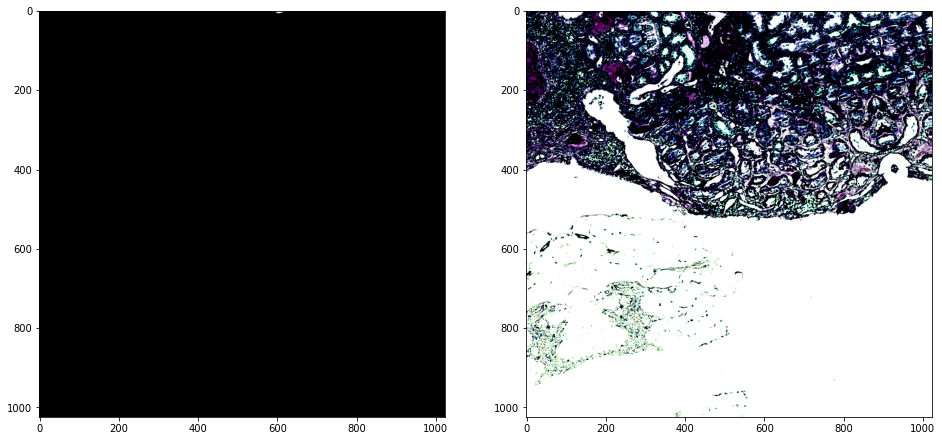

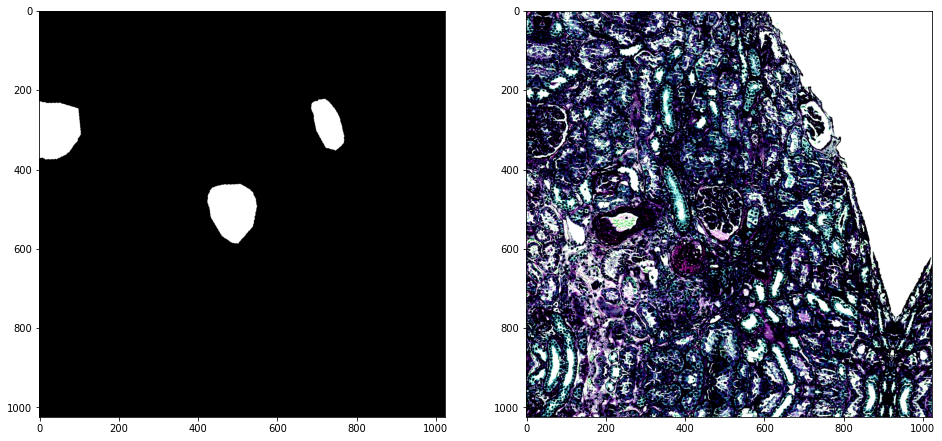

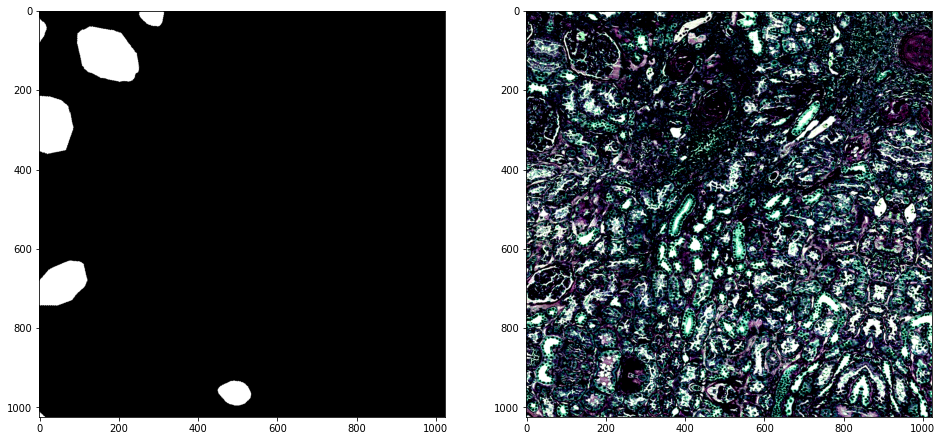

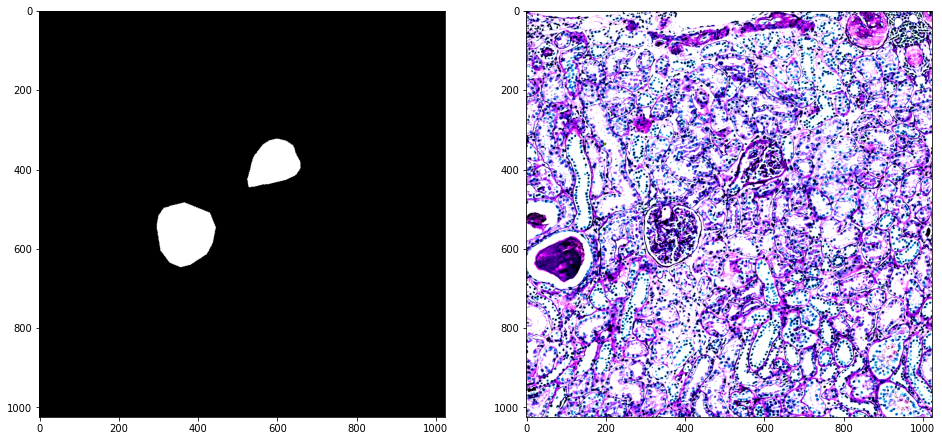

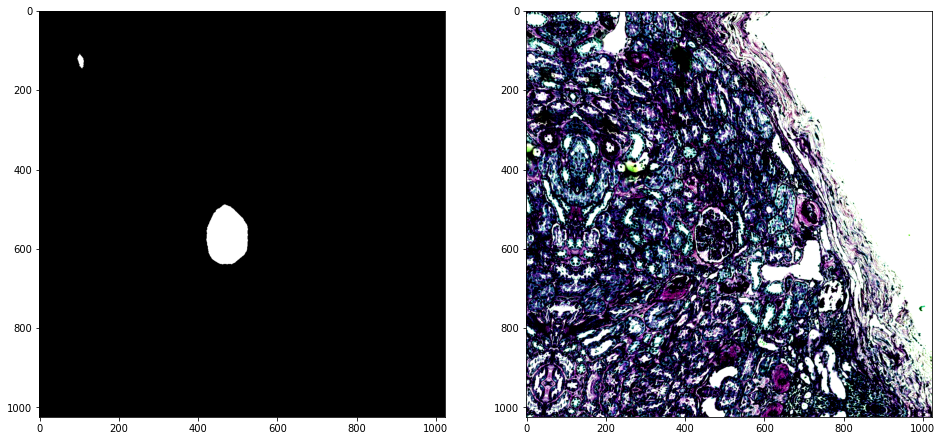

In [22]:
def display_mask_img(idx):
    image, mask = ds[idx]
    mask = mask.to(torch.uint8)
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    plt.imshow(mask[0], cmap='gray')
    plt.subplot(122)
    plt.imshow(np.moveaxis(image.numpy(), 0, -1));

for i in range(5):
    display_mask_img(i)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


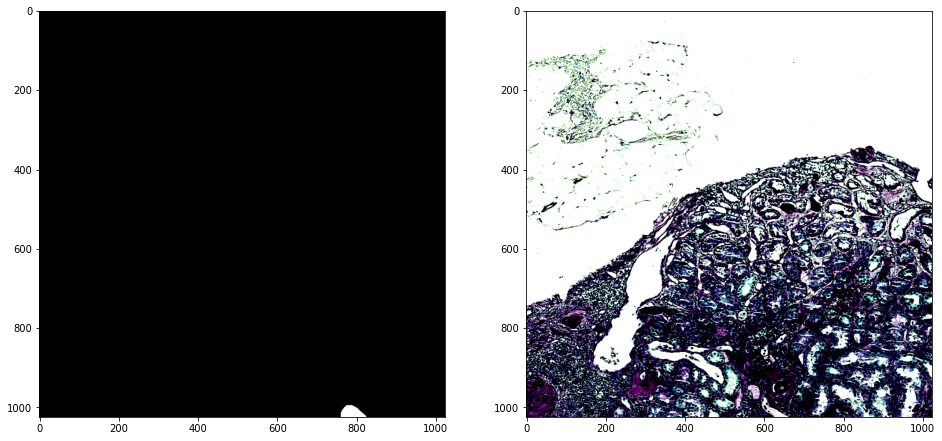

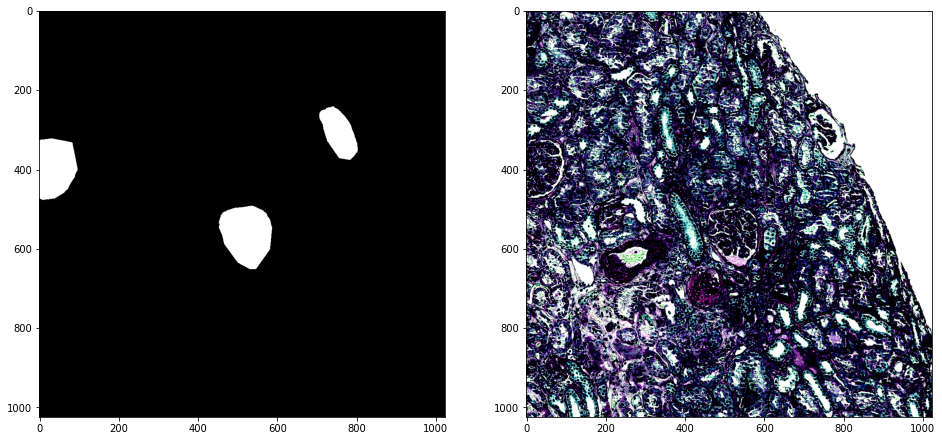

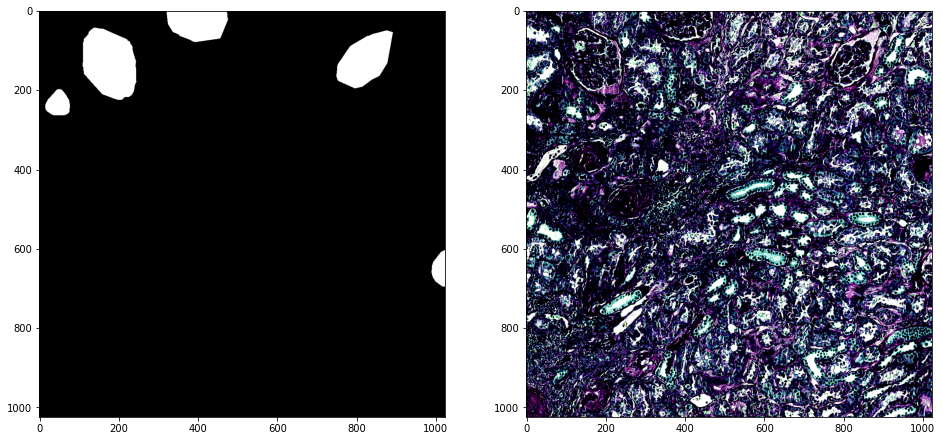

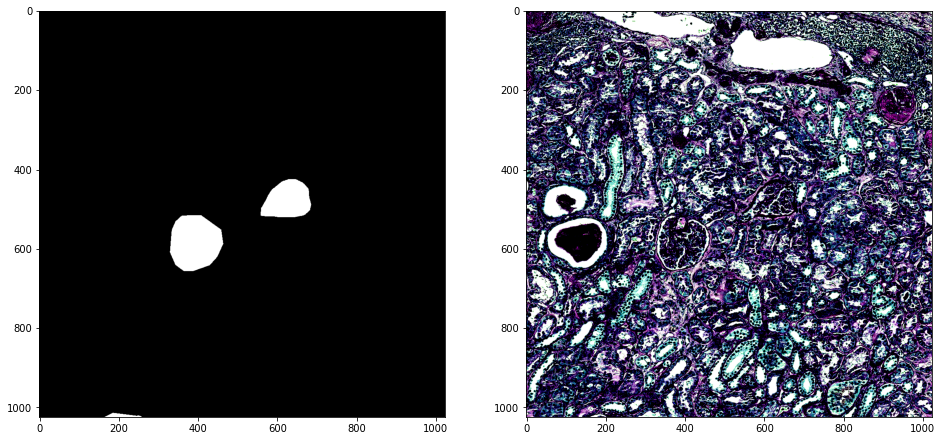

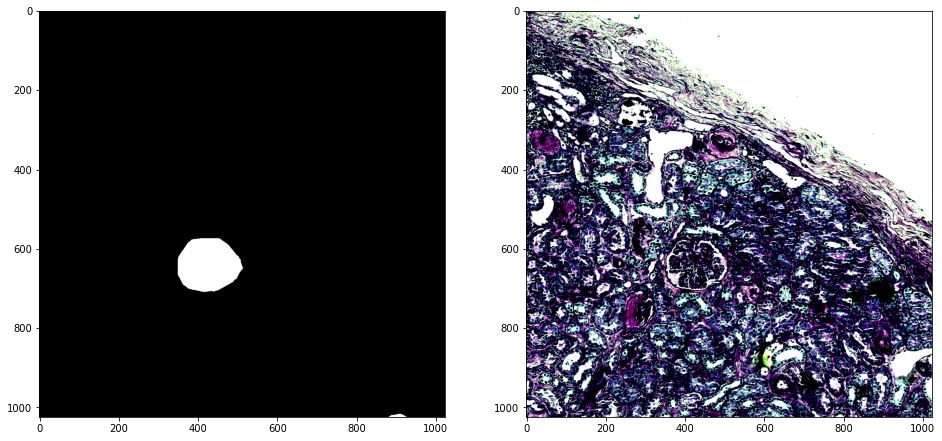

In [23]:
ds.mode = 'valid'

for i in range(5):
    display_mask_img(i)

In [24]:
image, mask = ds[0]

_ = rle_numba_encode(mask[0].numpy().astype('uint8')) # compile function with numba

In [25]:
image.shape

torch.Size([3, 1024, 1024])

#### Split

In [26]:
# Images and its corresponding masks are saved with the same filename.
def generate_fold_info(ds):
    groups = [ds.slices[i][0] for i in range(len(ds))]
    group_kfold = GroupKFold(n_splits = FOLDS)
    fold_info = [(train_idx, valid_idx) for fold, (train_idx, valid_idx) in tqdm(enumerate(group_kfold.split(ds.slices, 
                                                            groups = groups)), total=FOLDS)]
    return fold_info

In [27]:
fold_info = generate_fold_info(ds)

100%|██████████| 4/4 [00:00<00:00, 1291.85it/s]


#### Data loaders

In [28]:
import copy

def create_subset(ds, train_idx, valid_idx):
    train_ds = D.Subset(ds, train_idx)
    val_ds = copy.copy(ds)
    val_ds.mode = 'valid'
    valid_ds = D.Subset(val_ds, valid_idx)
    print(val_ds)
    return train_ds, valid_ds

In [29]:
def generate_train_valid_dls(ds, train_idx, valid_idx):
    train_ds, valid_ds = create_subset(ds, train_idx, valid_idx)

    num_workers = NUM_WORKERS
    # define training and validation data loaders
    train_dl = D.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)

    valid_dl = D.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
    return train_dl, valid_dl

### Model

In [30]:
class HuBMAPModel(nn.Module):
    def __init__(self):
        super(HuBMAPModel, self).__init__()
        args = {
            'encoder_name': ENCODER_NAME, 
            'encoder_weights': ENCODER_WEIGHTS,
            'classes': 1,
            'activation': None,
            'aux_params': None
        }
        if ARCH == 'unet':
            self.model = Unet(**args)
        elif ARCH == 'fpn':
            self.model = FPN(**args)
        elif ARCH == 'manet':
            self.model = MAnet(**args)
        elif ARCH == 'linknet':
            self.model = Linknet(**args)
        elif ARCH == 'pan':
            self.model = PAN(**args)
        
    def forward(self, images):
        return self.model(images)

In [31]:
def get_model():
    model = HuBMAPModel()
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)
    model.to(DEVICE)
    return model

### Training

In [32]:
def create_optimizer(model):
    return torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)

def create_optimizer_scheduler(model, train_dl, epochs):
    optimizer = create_optimizer(model)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
                                                    steps_per_epoch=len(train_dl), epochs=epochs)
    return optimizer, scheduler

### Loss

In [33]:
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):

        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, x, y):

        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)
        
        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()

        return 1 - dc
    
bce_fn = nn.BCEWithLogitsLoss()
dice_fn = SoftDiceLoss()

def loss_fn(y_pred, y_true):
    bce = bce_fn(y_pred, y_true)
    dice = dice_fn(y_pred.sigmoid(), y_true)
    return 0.5 * bce + 0.5 * dice

In [34]:
dice_loss = smp.losses.DiceLoss(mode='binary', from_logits=False)

def loss_fn(y_pred, y_true):
    return dice_loss(y_pred.sigmoid(), y_true)

In [35]:
LOSS_ALPHA = 0.4

def loss_fn(y_pred, y_true):
    return LOSS_ALPHA * dice_loss(y_pred.sigmoid(), y_true) + (1 - LOSS_ALPHA) * bce_fn(y_pred, y_true)

In [36]:
# jaccard_loss = smp.utils.losses.JaccardLoss()

# def loss_fn(y_pred, y_true):
#     return jaccard_loss(y_pred.sigmoid(), y_true)

In [37]:
def dice_metric(y_pred, y, epsilon = 1e-7):
    dims=(-2,-1)
    x = (y_pred > 0).float()
    dc = (2 * (x * y).sum(dims) + epsilon) / ((x + y).sum(dims) + epsilon)
    return dc.mean()

In [38]:
iou_metric = smp.utils.metrics.IoU(threshold=0.5)
dice_metric_2 = smp.utils.metrics.Fscore()

In [39]:
def gen_dls(fold):
    train_idx, valid_idx = fold_info[fold]
    print(f'Proportions valid / train: {len(valid_idx) / len(train_idx)}')
    train_dl, valid_dl = generate_train_valid_dls(ds, train_idx, valid_idx)
    return train_dl, valid_dl

In [40]:
from scripts.LRFinder import LRFinder

In [41]:
model = get_model()
lr_finder = LRFinder(model, create_optimizer(model), loss_fn, device="cuda")

Let's use 2 GPUs!


In [42]:
lr_find_dl, _ = gen_dls(0)
lr_finder.range_test(lr_find_dl, end_lr=100, num_iter=100)

  0%|          | 0/15 [00:00<?, ?it/s]

Proportions valid / train: 0.3285589009061678
Reading cached slices, files and masks


/opt/conda/lib/python3.6/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|██████████| 15/15 [00:03<00:00,  4.93it/s]


total: 4545, skipped: 0 mode: valid


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 1.67E-01


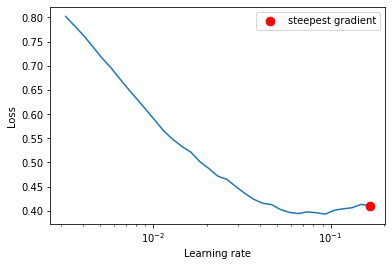

(<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>, 0.16681005372000585)

In [43]:
lr_finder.plot() # to inspect the loss-learning rate graph

In [44]:
lr_finder.reset() # to reset the model and optimizer to their initial state

In [46]:
LR = 2e-3

In [47]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
# def smooth_mask(mask, alpha = 0.9):
#     zeros_mask = (mask == 0).to(torch.float16) * (1 - alpha)
#     mask = mask * alpha
#     return mask + zeros_mask

def smooth_mask_2(mask, alpha = LABEL_SMOOTH):
    return (1 - alpha) * mask + alpha / 2

def train_epoch(model, dataloader, optim, criterion, scheduler, device="cpu", grad_accu_steps=GRAD_ACCU_STEPS):
    model.train()
    
    train_loss = []
    labels = []
    outs = []
    lrs = []
    
    tbar = tqdm(dataloader, position=0, leave=True)
    scaler = torch.cuda.amp.GradScaler() # mixed precision support
    scale = None
    for step, (image, target) in enumerate(tbar):
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        target = smooth_mask_2(target)
        
        with torch.cuda.amp.autocast():
            output = model(image)
            loss = criterion(output, target) / grad_accu_steps
        
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        if (step + 1) % grad_accu_steps == 0:
            scaler.step(optim)
            scale = scaler.get_scale()
            scaler.update()
            optim.zero_grad()
        
        skip_lr_sched = (scale != scaler.get_scale())
        if not skip_lr_sched:
            scheduler.step()
        
        loss_val = loss.item() * grad_accu_steps
        train_loss.append(loss_val)
        lrs.append(get_lr(optim))
        
        tbar.set_description('loss - {:.4f}'.format(loss_val))
        
    print(f'Train loss: {np.array(train_loss).mean()}')
    return train_loss, lrs

In [48]:
all_metrics = [dice_metric, dice_metric_2, iou_metric]

def val_epoch(model, dataloader, criterion, epoch, device="cpu"):
    model.eval()

    valid_loss = []
    num_corrects = 0
    num_total = 0
    labels = []
    outs = []
    metric_list = [[] for _ in all_metrics]

    for item in dataloader:
        image, target = item
        image, target = image.to(DEVICE), target.float().to(DEVICE)

        with torch.no_grad():
            output = model(image)
            loss = criterion(output, target)
            for ml, m in zip(metric_list, all_metrics):
                ml.append(m(output, target).item())
        valid_loss.append(loss.item())

    avg_loss = np.array(valid_loss).mean()
    print(f'Epoch {epoch} - valid loss: {avg_loss}')
    dice_metric_mean = np.array(metric_list[0]).mean()
    dice_metric_mean_2 = np.array(metric_list[1]).mean()
    iou_metric_mean = np.array(metric_list[2]).mean()
    return valid_loss, dice_metric_mean, avg_loss, iou_metric_mean, dice_metric_mean_2

In [49]:
def train(fold, epochs, train_dl, valid_dl, optimizer, scheduler, patience = 6):
    best_loss = 100.0
    best_metric = 0
    train_losses = []
    valid_losses = []
    accumulated_lrs = []
    accumulated_dice_metrics = []
    early_stop_counter = 0
    messages = []

    for epoch in tqdm(range(epochs), position=0, leave=True):
        train_loss, lrs = train_epoch(model, train_dl, optimizer, loss_fn, scheduler, DEVICE)
        valid_loss, dice_metric_mean, avg_loss, iou_metric_mean, dice_metric_mean_2 = val_epoch(model, valid_dl, loss_fn, epoch, DEVICE)
        train_losses += train_loss
        valid_losses.append(np.array(valid_loss).mean())
        accumulated_lrs += lrs
        accumulated_dice_metrics.append(dice_metric_mean)
        if best_metric < dice_metric_mean:
            best_metric = dice_metric_mean
            print('Saving model')
            if torch.cuda.device_count() > 1:
                torch.save(model.module.state_dict(), BEST_MODEL)
            else:
                torch.save(model.state_dict(), BEST_MODEL)
            early_stop_counter = 0
        else:
            early_stop_counter += 1
        if best_loss > avg_loss:
            best_loss = avg_loss
        print(f'Epoch {epoch} - val best loss {best_loss} dice metric ({dice_metric_mean}, {dice_metric_mean_2}) iou metric ({iou_metric_mean}).')
        messages.append({
            'fold': fold,
            'epoch': epoch,
            'avg_loss': avg_loss,
            'best_loss': best_loss,
            'dice_metric_mean': dice_metric_mean,
            'dice_coeff_mean': dice_metric_mean_2,
            'iou_metric_mean': iou_metric_mean
        })
        with open(REPORT_PATH/f'{EXPERIMENT_NAME}_fold_{fold}', 'w') as outfile:
            json.dump(messages, outfile)
        if early_stop_counter >= patience:
            print('Stopping early')
            break
    
    return train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics

In [50]:
def train_split(fold_info, fold):
    global model
    
    print(f'Processing fold {fold}')
    model = get_model()
    train_dl, valid_dl = gen_dls(fold)
    optimizer, scheduler = create_optimizer_scheduler(model, train_dl, EPOCHS)
    train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics = train(fold, EPOCHS, train_dl, valid_dl, optimizer, scheduler, patience = PATIENCE)
    return train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics

In [51]:
def train_split_and_move(fold_info, fold):
    train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics = train_split(fold_info, fold)
    !mv {BEST_MODEL} {fold}_{BEST_MODEL}
    stats_df = pd.DataFrame({'train_losses': train_losses, 'accumulated_lrs': accumulated_lrs})
    stats_df[['train_losses']].plot()
    val_stats_df = pd.DataFrame({'valid_losses': valid_losses})
    val_stats_df[['valid_losses']].plot()

Processing fold 0
Let's use 2 GPUs!
Proportions valid / train: 0.3285589009061678


  0%|          | 0/15 [00:00<?, ?it/s]

Reading cached slices, files and masks


  0%|          | 0/571 [00:00<?, ?it/s]

total: 4545, skipped: 0 mode: valid


/opt/conda/lib/python3.6/site-packages/torch/functional.py:1242: UserWarning: torch.norm is deprecated and may be removed in a future PyTorch release. Use torch.linalg.norm instead.
  "torch.norm is deprecated and may be removed in a future PyTorch release. "
loss - 0.1843: 100%|██████████| 571/571 [10:16<00:00,  1.08s/it]


Train loss: 0.39177310094889745
Epoch 0 - valid loss: 0.0879019237460291
Saving model


  0%|          | 0/571 [00:00<?, ?it/s]06.09s/it]

Epoch 0 - val best loss 0.0879019237460291 dice metric (0.8506217541846823, 0.9017910282028482) iou metric (0.8231778534802985).


loss - 0.0784: 100%|██████████| 571/571 [10:18<00:00,  1.08s/it]

Train loss: 0.09129875788755466


Epoch 1 - valid loss: 0.04742019992083945
Saving model


  0%|          | 0/571 [00:00<?, ?it/s]07.53s/it]

Epoch 1 - val best loss 0.04742019992083945 dice metric (0.8959661964723404, 0.9326794623060429) iou metric (0.8753045429574683).


loss - 0.0681: 100%|██████████| 571/571 [10:18<00:00,  1.08s/it]

Train loss: 0.08085375313113742


Epoch 2 - valid loss: 0.044678016783709223
Saving model


  0%|          | 0/571 [00:00<?, ?it/s]08.23s/it]

Epoch 2 - val best loss 0.044678016783709223 dice metric (0.9000970114101755, 0.9363651779737878) iou metric (0.8814265391928084).


loss - 0.0626: 100%|██████████| 571/571 [10:17<00:00,  1.08s/it]

Train loss: 0.08025020262431973



  0%|          | 0/571 [00:00<?, ?it/s]07.90s/it]

Epoch 3 - valid loss: 0.04610630741065487
Epoch 3 - val best loss 0.044678016783709223 dice metric (0.8953502420732316, 0.9354949625248604) iou metric (0.8801606405288616).


loss - 0.0893: 100%|██████████| 571/571 [10:18<00:00,  1.08s/it]


Train loss: 0.07988336707763831


  0%|          | 0/571 [00:00<?, ?it/s]07.94s/it]

Epoch 4 - valid loss: 0.04738866109797295
Epoch 4 - val best loss 0.044678016783709223 dice metric (0.8984945736666943, 0.9329863086025766) iou metric (0.8758350420505443).


loss - 0.0796: 100%|██████████| 571/571 [10:18<00:00,  1.08s/it]

Train loss: 0.07965207609450754



  0%|          | 0/571 [00:00<?, ?it/s] 707.90s/it]

Epoch 5 - valid loss: 0.05266178650979666
Epoch 5 - val best loss 0.044678016783709223 dice metric (0.8878712788858312, 0.9245817708842298) iou metric (0.8613939871813389).


loss - 0.1375: 100%|██████████| 571/571 [10:17<00:00,  1.08s/it]

Train loss: 0.0775643852384412


Epoch 6 - valid loss: 0.04676773723095973
Saving model


  0%|          | 0/571 [00:00<?, ?it/s] 707.98s/it]

Epoch 6 - val best loss 0.044678016783709223 dice metric (0.9007708970853623, 0.9330640983708361) iou metric (0.876846803946698).


loss - 0.2545: 100%|██████████| 571/571 [10:18<00:00,  1.08s/it]


Train loss: 0.07614250595301338


  0%|          | 0/571 [00:00<?, ?it/s] 708.09s/it]

Epoch 7 - valid loss: 0.05110024828265639
Epoch 7 - val best loss 0.044678016783709223 dice metric (0.8898233306851793, 0.9273085299324482) iou metric (0.8670721971925269).


loss - 0.1314: 100%|██████████| 571/571 [10:17<00:00,  1.08s/it]


Train loss: 0.07420911799118106
Epoch 8 - valid loss: 0.0423730008720242
Saving model


  0%|          | 0/571 [00:00<?, ?it/s] 708.12s/it]

Epoch 8 - val best loss 0.0423730008720242 dice metric (0.9049519520807774, 0.9381258817429238) iou metric (0.8850891206492769).


loss - 0.0684: 100%|██████████| 571/571 [10:18<00:00,  1.08s/it]

Train loss: 0.07217643944947816


Epoch 9 - valid loss: 0.04182092928664481
Saving model


  0%|          | 0/571 [00:00<?, ?it/s], 708.34s/it]

Epoch 9 - val best loss 0.04182092928664481 dice metric (0.9096359250710365, 0.9398363521124454) iou metric (0.8878691339112342).


loss - 0.2673: 100%|██████████| 571/571 [10:18<00:00,  1.08s/it]

Train loss: 0.07094443838671502



  0%|          | 0/571 [00:00<?, ?it/s], 708.35s/it]

Epoch 10 - valid loss: 0.04766774852264752
Epoch 10 - val best loss 0.04182092928664481 dice metric (0.8912512431753442, 0.9322498076139613) iou metric (0.8748139250785747).


loss - 0.0666: 100%|██████████| 571/571 [10:18<00:00,  1.08s/it]

Train loss: 0.06917197663734966



  0%|          | 0/571 [00:00<?, ?it/s], 708.26s/it]

Epoch 11 - valid loss: 0.049567757293264916
Epoch 11 - val best loss 0.04182092928664481 dice metric (0.8992880234058868, 0.9291682240176709) iou metric (0.869589867109948).


loss - 0.1345: 100%|██████████| 571/571 [10:18<00:00,  1.08s/it]


Train loss: 0.06753409294421327
Epoch 12 - valid loss: 0.04096741165886534
Saving model


  0%|          | 0/571 [00:00<?, ?it/s], 708.41s/it]

Epoch 12 - val best loss 0.04096741165886534 dice metric (0.9099903707491591, 0.9411615019148969) iou metric (0.8900372053080416).


loss - 0.1012: 100%|██████████| 571/571 [10:18<00:00,  1.08s/it]

Train loss: 0.06570410915045312



  0%|          | 0/571 [00:00<?, ?it/s], 708.21s/it]

Epoch 13 - valid loss: 0.04220019891224009
Epoch 13 - val best loss 0.04096741165886534 dice metric (0.9076812639832497, 0.9396258779662721) iou metric (0.8874471098818677).


loss - 0.0810: 100%|██████████| 571/571 [10:18<00:00,  1.08s/it]

Train loss: 0.06471735024384358



  0%|          | 0/571 [00:00<?, ?it/s]708.19s/it]  

Epoch 14 - valid loss: 0.04318920806288085
Epoch 14 - val best loss 0.04096741165886534 dice metric (0.9053892452032009, 0.9384819269180298) iou metric (0.8852986411211339).


loss - 0.0608: 100%|██████████| 571/571 [10:19<00:00,  1.09s/it]

Train loss: 0.06356899602087492



  0%|          | 0/571 [00:00<?, ?it/s]708.76s/it]

Epoch 15 - valid loss: 0.0433901291578374
Epoch 15 - val best loss 0.04096741165886534 dice metric (0.9085944703918822, 0.9387449327301471) iou metric (0.8860875374459206).


loss - 0.0528: 100%|██████████| 571/571 [10:19<00:00,  1.09s/it]


Train loss: 0.0628469009245966


  0%|          | 0/571 [00:00<?, ?it/s]709.10s/it]

Epoch 16 - valid loss: 0.04316837189996496
Epoch 16 - val best loss 0.04096741165886534 dice metric (0.907311386408958, 0.9382321679211677) iou metric (0.8849490893648025).


loss - 0.0567: 100%|██████████| 571/571 [10:19<00:00,  1.09s/it]

Train loss: 0.06199557807185604


Epoch 17 - valid loss: 0.04212272207827327
Saving model


  0%|          | 0/571 [00:00<?, ?it/s]709.64s/it]

Epoch 17 - val best loss 0.04096741165886534 dice metric (0.9111999328783218, 0.9405068333478684) iou metric (0.8889593843449938).


loss - 0.0737: 100%|██████████| 571/571 [10:19<00:00,  1.09s/it]

Train loss: 0.061585834761999955



  0%|          | 0/571 [00:00<?, ?it/s]709.69s/it]

Epoch 18 - valid loss: 0.04307886130830392
Epoch 18 - val best loss 0.04096741165886534 dice metric (0.908890869864758, 0.9393618950184356) iou metric (0.886975940871746).


loss - 0.0715: 100%|██████████| 571/571 [10:19<00:00,  1.08s/it]


Train loss: 0.06140256893613919


100%|██████████| 20/20 [3:56:11<00:00, 708.60s/it]

Epoch 19 - valid loss: 0.043490973588554784
Epoch 19 - val best loss 0.04096741165886534 dice metric (0.9090877604928422, 0.93848003668988) iou metric (0.8856305410253241).


CPU times: user 5h 6min 50s, sys: 1h 20min 42s, total: 6h 27min 32s
Wall time: 3h 56min 17s


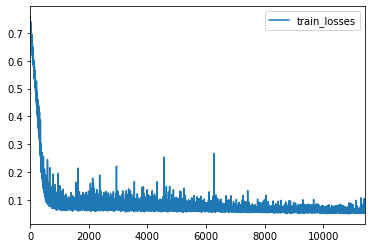

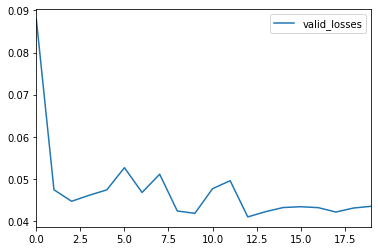

In [52]:
%%time
train_split_and_move(fold_info, 0)

Processing fold 1
Let's use 2 GPUs!
Proportions valid / train: 0.3399174528301887


  0%|          | 0/15 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
  7%|▋         | 1/15 [00:00<00:01,  9.30it/s]

Reading cached slices, files and masks


  0%|          | 0/566 [00:00<?, ?it/s]

total: 4545, skipped: 0 mode: valid


/opt/conda/lib/python3.6/site-packages/torch/functional.py:1242: UserWarning: torch.norm is deprecated and may be removed in a future PyTorch release. Use torch.linalg.norm instead.
  "torch.norm is deprecated and may be removed in a future PyTorch release. "
loss - 0.2124: 100%|██████████| 566/566 [10:14<00:00,  1.09s/it]


Train loss: 0.41658422547020674
Epoch 0 - valid loss: 0.08126804877284895
Saving model


  0%|          | 0/566 [00:00<?, ?it/s]07.58s/it]

Epoch 0 - val best loss 0.08126804877284895 dice metric (0.8778393172847174, 0.9135134136738555) iou metric (0.841837139018459).


loss - 0.0993: 100%|██████████| 566/566 [10:14<00:00,  1.09s/it]


Train loss: 0.09419844901129971
Epoch 1 - valid loss: 0.04493242656628703
Saving model


  0%|          | 0/566 [00:00<?, ?it/s]08.02s/it]

Epoch 1 - val best loss 0.04493242656628703 dice metric (0.9102391189861792, 0.9380737660462375) iou metric (0.8843992089978154).


loss - 0.0623: 100%|██████████| 566/566 [10:15<00:00,  1.09s/it]


Train loss: 0.08247599224214419
Epoch 2 - valid loss: 0.039387869605205836
Saving model


  0%|          | 0/566 [00:00<?, ?it/s]08.13s/it]

Epoch 2 - val best loss 0.039387869605205836 dice metric (0.9179158677091253, 0.9428256215826835) iou metric (0.8924015572034015).


loss - 0.1238: 100%|██████████| 566/566 [10:14<00:00,  1.09s/it]

Train loss: 0.0810200210015681



  0%|          | 0/566 [00:00<?, ?it/s]07.80s/it]

Epoch 3 - valid loss: 0.04895515431085399
Epoch 3 - val best loss 0.039387869605205836 dice metric (0.9021658495917839, 0.9344377567113372) iou metric (0.8782048716446279).


loss - 0.0717: 100%|██████████| 566/566 [10:15<00:00,  1.09s/it]


Train loss: 0.0812605385448086


  0%|          | 0/566 [00:00<?, ?it/s]07.82s/it]

Epoch 4 - valid loss: 0.042324139365028844
Epoch 4 - val best loss 0.039387869605205836 dice metric (0.9132421640534475, 0.9401294684780694) iou metric (0.8881504788917581).


loss - 0.4513: 100%|██████████| 566/566 [10:14<00:00,  1.09s/it]

Train loss: 0.08107482291126208



  0%|          | 0/566 [00:00<?, ?it/s] 707.57s/it]

Epoch 5 - valid loss: 0.04443601266012908
Epoch 5 - val best loss 0.039387869605205836 dice metric (0.905544038881292, 0.939444980164266) iou metric (0.8867882221473931).


loss - 0.1394: 100%|██████████| 566/566 [10:14<00:00,  1.09s/it]


Train loss: 0.0800264296467439


  0%|          | 0/566 [00:00<?, ?it/s] 707.52s/it]

Epoch 6 - valid loss: 0.04605559751854659
Epoch 6 - val best loss 0.039387869605205836 dice metric (0.9037388380945037, 0.9355354599384447) iou metric (0.879870834437059).


loss - 0.0841: 100%|██████████| 566/566 [10:14<00:00,  1.09s/it]


Train loss: 0.07736510498442624
Epoch 7 - valid loss: 0.04023848268459189
Saving model


  0%|          | 0/566 [00:00<?, ?it/s] 707.66s/it]

Epoch 7 - val best loss 0.039387869605205836 dice metric (0.9184027922585838, 0.9437212493135522) iou metric (0.8940446481803538).


loss - 0.0895: 100%|██████████| 566/566 [10:14<00:00,  1.09s/it]

Train loss: 0.07555650036400283



  0%|          | 0/566 [00:00<?, ?it/s] 707.45s/it]

Epoch 8 - valid loss: 0.03995871596964839
Epoch 8 - val best loss 0.039387869605205836 dice metric (0.9175813235149483, 0.9425769052974918) iou metric (0.8922016478573103).


loss - 0.0594: 100%|██████████| 566/566 [10:14<00:00,  1.09s/it]


Train loss: 0.07376289364384889


  0%|          | 0/566 [00:00<?, ?it/s], 707.34s/it]

Epoch 9 - valid loss: 0.03958739450326855
Epoch 9 - val best loss 0.039387869605205836 dice metric (0.9179190644328459, 0.9432651873079606) iou metric (0.8932607510546946).


loss - 0.0832: 100%|██████████| 566/566 [10:14<00:00,  1.09s/it]


Train loss: 0.0721928441153293


  0%|          | 0/566 [00:00<?, ?it/s], 707.25s/it]

Epoch 10 - valid loss: 0.03928401864524641
Epoch 10 - val best loss 0.03928401864524641 dice metric (0.9170869591940253, 0.9445955166544939) iou metric (0.8956924717043347).


loss - 0.0736: 100%|██████████| 566/566 [10:14<00:00,  1.09s/it]


Train loss: 0.0701360274632807
Epoch 11 - valid loss: 0.0379264968703139
Saving model


  0%|          | 0/566 [00:00<?, ?it/s], 707.33s/it]

Epoch 11 - val best loss 0.0379264968703139 dice metric (0.9274699246327494, 0.946517826053145) iou metric (0.8991045920960026).


loss - 0.0740: 100%|██████████| 566/566 [10:14<00:00,  1.09s/it]

Train loss: 0.06880020402872099



  0%|          | 0/566 [00:00<?, ?it/s], 707.30s/it]

Epoch 12 - valid loss: 0.03834404313811367
Epoch 12 - val best loss 0.0379264968703139 dice metric (0.9203108017926389, 0.9460968999047353) iou metric (0.8983611677594753).


loss - 0.0808: 100%|██████████| 566/566 [10:14<00:00,  1.09s/it]

Train loss: 0.06712709404133234


Epoch 13 - valid loss: 0.03690656324742372
Saving model


  0%|          | 0/566 [00:00<?, ?it/s], 707.47s/it]

Epoch 13 - val best loss 0.03690656324742372 dice metric (0.9278116683268176, 0.9487348893763488) iou metric (0.9030152611781896).


loss - 0.0652:  18%|█▊        | 100/566 [01:50<08:26,  1.09s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

loss - 0.0545: 100%|██████████| 566/566 [10:14<00:00,  1.09s/it]


Train loss: 0.0624268281573015


100%|██████████| 20/20 [3:55:48<00:00, 707.43s/it]

Epoch 19 - valid loss: 0.03688234747073811
Epoch 19 - val best loss 0.0367666301775936 dice metric (0.9266560954751129, 0.9493337285951011) iou metric (0.9039396875262878).


CPU times: user 5h 7min 4s, sys: 1h 19min 34s, total: 6h 26min 39s
Wall time: 3h 55min 53s


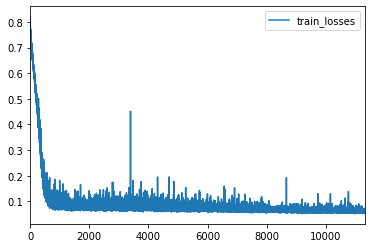

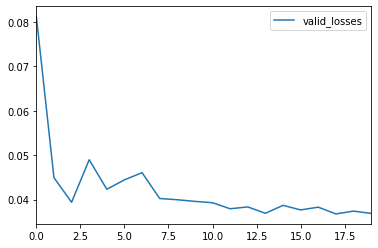

In [53]:
%%time
train_split_and_move(fold_info, 1)

In [54]:
%%time
train_split_and_move(fold_info, 2)

Processing fold 2
Let's use 2 GPUs!
Proportions valid / train: 0.33715798764342453


  0%|          | 0/15 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
  7%|▋         | 1/15 [00:00<00:01,  9.74it/s]

Reading cached slices, files and masks


  0%|          | 0/567 [00:00<?, ?it/s]

total: 4545, skipped: 0 mode: valid


/opt/conda/lib/python3.6/site-packages/torch/functional.py:1242: UserWarning: torch.norm is deprecated and may be removed in a future PyTorch release. Use torch.linalg.norm instead.
  "torch.norm is deprecated and may be removed in a future PyTorch release. "
loss - 0.1315: 100%|██████████| 567/567 [10:16<00:00,  1.09s/it]

Train loss: 0.5200068317025217


Epoch 0 - valid loss: 0.13119442905274986
Saving model


  0%|          | 0/567 [00:00<?, ?it/s]08.83s/it]

Epoch 0 - val best loss 0.13119442905274986 dice metric (0.8155228640708624, 0.8642690035061062) iou metric (0.7687318716685809).


loss - 0.1330: 100%|██████████| 567/567 [10:16<00:00,  1.09s/it]

Train loss: 0.09544832865186889


Epoch 1 - valid loss: 0.061734806795004774
Saving model


  0%|          | 0/567 [00:00<?, ?it/s]08.89s/it]

Epoch 1 - val best loss 0.061734806795004774 dice metric (0.8635757206622219, 0.9106111610747133) iou metric (0.8431410218408595).


loss - 0.0751:  61%|██████    | 347/567 [06:18<03:56,  1.07s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

loss - 0.0689: 100%|██████████| 567/567 [10:15<00:00,  1.09s/it]

Train loss: 0.07248715085931766



  0%|          | 0/567 [00:00<?, ?it/s] 707.57s/it]

Epoch 8 - valid loss: 0.06152543833196475
Epoch 8 - val best loss 0.057872483253244955 dice metric (0.8582367695750991, 0.909586399949658) iou metric (0.8421428312805934).


loss - 0.0643: 100%|██████████| 567/567 [10:15<00:00,  1.09s/it]

Train loss: 0.0704866406594845



  0%|          | 0/567 [00:00<?, ?it/s], 707.47s/it]

Epoch 9 - valid loss: 0.05918411953443008
Epoch 9 - val best loss 0.057872483253244955 dice metric (0.8678850743783082, 0.9129012055421999) iou metric (0.8480739524071129).


loss - 0.0613:  65%|██████▍   | 367/567 [06:38<03:35,  1.08s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [55]:
%%time
train_split_and_move(fold_info, 3)

Processing fold 3
Let's use 2 GPUs!
Proportions valid / train: 0.32778264680105174


  0%|          | 0/15 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
  7%|▋         | 1/15 [00:00<00:01,  9.58it/s]

Reading cached slices, files and masks


  0%|          | 0/571 [00:00<?, ?it/s]

total: 4545, skipped: 0 mode: valid


/opt/conda/lib/python3.6/site-packages/torch/functional.py:1242: UserWarning: torch.norm is deprecated and may be removed in a future PyTorch release. Use torch.linalg.norm instead.
  "torch.norm is deprecated and may be removed in a future PyTorch release. "
loss - 0.3220: 100%|██████████| 571/571 [10:19<00:00,  1.09s/it]

Train loss: 0.5565231131118985


Epoch 0 - valid loss: 0.1457876915281469
Saving model


  0%|          | 0/571 [00:00<?, ?it/s]09.92s/it]

Epoch 0 - val best loss 0.1457876915281469 dice metric (0.8083698006476311, 0.866497635044516) iou metric (0.7761352058241074).


loss - 0.1200: 100%|██████████| 571/571 [10:19<00:00,  1.09s/it]

Train loss: 0.09809218292269732


Epoch 1 - valid loss: 0.05728485426282819
Saving model


  0%|          | 0/571 [00:00<?, ?it/s]10.18s/it]

Epoch 1 - val best loss 0.05728485426282819 dice metric (0.8741004264609699, 0.9208738093070168) iou metric (0.8589204368106822).


loss - 0.0750:  60%|█████▉    | 340/571 [06:09<04:09,  1.08s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

loss - 0.0587: 100%|██████████| 571/571 [10:19<00:00,  1.09s/it]


Train loss: 0.07596920749691238


  0%|          | 0/571 [00:00<?, ?it/s] 709.75s/it]

Epoch 7 - valid loss: 0.05002745823625893
Epoch 7 - val best loss 0.04834448279225253 dice metric (0.8807134457769241, 0.9281187781038132) iou metric (0.8692057572584101).


loss - 0.0729: 100%|██████████| 571/571 [10:19<00:00,  1.09s/it]


Train loss: 0.0743550889768137


  0%|          | 0/571 [00:00<?, ?it/s] 709.74s/it]

Epoch 8 - valid loss: 0.05239692764645592
Epoch 8 - val best loss 0.04834448279225253 dice metric (0.8844209091867355, 0.9257485025069293) iou metric (0.8670033861927807).


loss - 0.0858: 100%|██████████| 571/571 [10:19<00:00,  1.08s/it]


Train loss: 0.07247673523744434


  0%|          | 0/571 [00:00<?, ?it/s], 709.58s/it]

Epoch 9 - valid loss: 0.05404643812042507
Epoch 9 - val best loss 0.04834448279225253 dice metric (0.882929199997754, 0.9231525359944226) iou metric (0.8634536008146357).


loss - 0.0746:  44%|████▍     | 252/571 [04:35<05:44,  1.08s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

loss - 0.1242: 100%|██████████| 571/571 [10:19<00:00,  1.09s/it]


Train loss: 0.06418262240713407


  0%|          | 0/571 [00:00<?, ?it/s]709.59s/it]

Epoch 15 - valid loss: 0.048857812087405174
Epoch 15 - val best loss 0.04343942627509966 dice metric (0.8959881964533086, 0.9323717138983987) iou metric (0.8759609231336869).


loss - 0.0598: 100%|██████████| 571/571 [10:19<00:00,  1.08s/it]

Train loss: 0.06357299734800793



  0%|          | 0/571 [00:00<?, ?it/s]709.47s/it]

Epoch 16 - valid loss: 0.04576918680997775
Epoch 16 - val best loss 0.04343942627509966 dice metric (0.8998689065005052, 0.93617564089158) iou metric (0.8817219874438118).


loss - 0.0813: 100%|██████████| 571/571 [10:19<00:00,  1.09s/it]

Train loss: 0.06268020986127561



  0%|          | 0/571 [00:00<?, ?it/s]709.57s/it]

Epoch 17 - valid loss: 0.047492335734759424
Epoch 17 - val best loss 0.04343942627509966 dice metric (0.8956971614756049, 0.9336337447166443) iou metric (0.8779258138355724).


loss - 0.0562:  14%|█▍        | 79/571 [01:27<08:48,  1.07s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
!mv *.pth models

In [ ]:
!ls